# Advanced Use: Gauss–Newton Covariance Estimation
## 1. Introduction
Digital image correlation (DIC) pipelines are often validated by running Monte Carlo experiments in which synthetic noise is injected into the deformed image. While this approach quantifies how a specific realization of sensor noise perturbs the solution, it mixes observability, texture quality, and random draws. In contrast, a covariance analysis linearized at the converged solution isolates the conditioning of the inverse problem itself.

In the Gauss–Newton or Laplace approximation the posterior of the unknown nodal displacements is locally Gaussian with covariance $(J^	op J)^{-1}\sigma_I^2$, where $J$ is the Jacobian of the pixel residuals with respect to nodal degrees of freedom (DOFs) and $\sigma_I$ denotes the image noise scale. Computing this covariance explicitly is infeasible for large FE-DIC problems, yet automatic differentiation (AD) provides Jacobian–vector products (JVPs) and vector–Jacobian products (VJPs) that let us work with $J$ implicitly and apply iterative solvers.

This notebook reuses the exact dataset, mesh, solver, and visualization tools introduced in *Simple2D_DIC.ipynb*. It demonstrates how to:

1. obtain a converged global FE-DIC solution $u_\star$ and the associated nodal Green–Lagrange strain field,
2. linearize the residuals $r(u)$ at $u_\star$ and expose the Gauss–Newton operator $J^	op J$ using only `jax.jvp`/`jax.linear_transpose`,
3. estimate displacement variances by solving linear systems with conjugate gradients (CG) without assembling dense Jacobians, and
4. push the covariance forward through the strain operator to obtain uncertainty maps on $E_{xx}$, $E_{yy}$, and $E_{xy}$ expressed in micro-strain ($\mu \varepsilon$).



All computations take place at convergence and depend solely on the deterministic conditioning of the problem—no Monte Carlo sampling of image noise is required to interpret the resulting observability maps.

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import sys

def find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for candidate in [start, *start.parents]:
        if (candidate / "doc" / "img" / "PlateHole").exists():
            return candidate
    raise FileNotFoundError("Could not locate the repository root (doc/img/PlateHole folder missing).")

repo_root = find_repo_root(Path.cwd())
coorjax_root = repo_root / "CoorJAx"
if str(coorjax_root) not in sys.path:
    sys.path.insert(0, str(coorjax_root))

import jax
import jax.numpy as jnp
import jax.random as random
from jax.scipy.sparse.linalg import cg
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

from CoorJAx.D2IC.dic import Dic
from D2IC.dic_plotter import DICPlotter
from D2IC import generate_roi_mesh
from D2IC.PixelQuad import (
    compute_pixel_state,
    compute_green_lagrange_strain_nodes_lsq,
    compute_image_gradient,
)

#jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

repo_root

PosixPath('/workspaces/08_dic')

## 2. Reference DIC Solution
We reuse the PlateHole experiment from *Simple2D_DIC.ipynb*. The same mesh, solver options, and visualization utilities are employed so that the covariance study can be interpreted directly on top of previously validated strain maps.

im_ref: (1040, 400) float32
im_def: (1040, 400) float32
mask : (1040, 400, 4) uint8


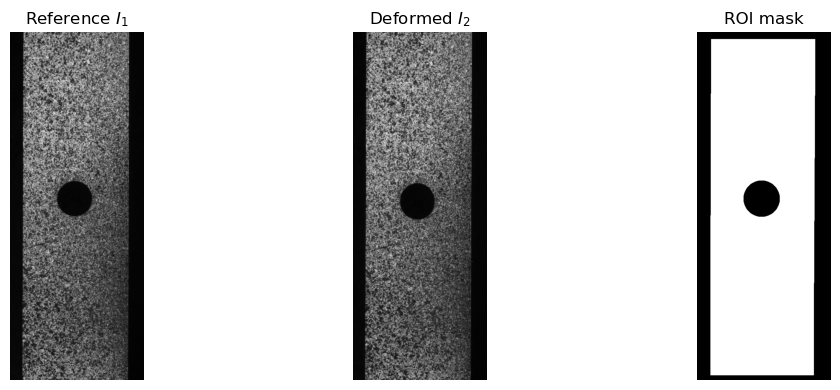

In [2]:
img_dir = repo_root / "doc" / "img" / "PlateHole"
out_dir = repo_root / "CoorJAx" / "doc" / "_outputs"
out_dir.mkdir(exist_ok=True)

im_ref = imread(img_dir / "ohtcfrp_00.tif").astype(np.float32)
im_def = imread(img_dir / "ohtcfrp_10.tif").astype(np.float32)
mask = imread(img_dir / "roi.tif")

print("im_ref:", im_ref.shape, im_ref.dtype)
print("im_def:", im_def.shape, im_def.dtype)
print("mask :", mask.shape, mask.dtype)

fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
ax[0].imshow(im_ref, cmap="gray", origin="lower")
ax[0].set_title("Reference $I_1$")
ax[1].imshow(im_def, cmap="gray", origin="lower")
ax[1].set_title("Deformed $I_2$")
ax[2].imshow(mask, cmap="gray", origin="lower")
ax[2].set_title("ROI mask")
for a in ax:
    a.axis("off")
plt.tight_layout()
plt.show()

In [3]:
mask_path = img_dir / "roi.tif"
mesh_path = out_dir / "Advanced_Use_Gauss_Newton_covariance_roi_mesh_40px.msh"

mesh_path_generated = generate_roi_mesh(mask_path, element_size=12.0, msh_path=str(mesh_path))
if mesh_path_generated is None:
    raise RuntimeError("Mesh generation failed.")
mesh_path = Path(mesh_path_generated)
mesh_path

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Circle)
Info    : [ 70%] Meshing curve 6 (Circle)
Info    : [ 80%] Meshing curve 7 (Circle)
Info    : [ 90%] Meshing curve 8 (Circle)
Info    : Done meshing 1D (Wall 0.000657236s, CPU 0.000607s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Blossom: 7623 internal 252 closed
Info    : Blossom recombination completed (Wall 0.0616726s, CPU 0.060695s): 2525 quads, 0 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.794731, min Q = 0.503638
Info    : Done meshing 2D (Wall 0.0960869s, CPU 0.090073s)
Info    : 2655 nodes 2789 elements
Info    : Writing '/workspaces/08_dic/CoorJAx/doc/_outputs/Advanced_Use_Gauss_Newton_covariance_roi_mesh_40px.msh'...
Info    : Done writing '/workspaces/08_dic/CoorJAx/doc/_outputs/Advanced_Use_G

PosixPath('/workspaces/08_dic/CoorJAx/doc/_outputs/Advanced_Use_Gauss_Newton_covariance_roi_mesh_40px.msh')

In [4]:
dic = Dic(mesh_path=str(mesh_path))
dic.precompute_pixel_data(jnp.asarray(im_ref))
dic

W1215 13:53:41.364092   50014 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1215 13:53:41.367654   49819 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


Retained matches: 9


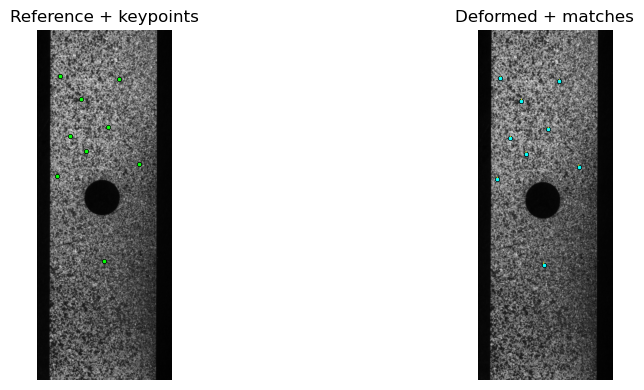

In [6]:
disp_guess, extras = dic.compute_feature_disp_guess_big_motion(
    im_ref,
    im_def,
    n_patches=32,
    patch_win=21,
    patch_search=15,
    refine=True,
    search_dilation=5.0,
)

pts_ref = extras["pts_ref"]
pts_def = extras["pts_def"]
print("Retained matches:", pts_ref.shape[0])

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
ax[0].imshow(im_ref, cmap="gray", origin="lower")
ax[0].scatter(pts_ref[:, 0], pts_ref[:, 1], s=10, c="lime", edgecolors="k", linewidths=0.5)
ax[0].set_title("Reference + keypoints")

ax[1].imshow(im_def, cmap="gray", origin="lower")
ax[1].scatter(pts_def[:, 0], pts_def[:, 1], s=10, c="cyan", edgecolors="k", linewidths=0.5)
ax[1].quiver(
    pts_ref[:, 0],
    pts_ref[:, 1],
    pts_def[:, 0] - pts_ref[:, 0],
    pts_def[:, 1] - pts_ref[:, 1],
    angles="xy",
    scale_units="xy",
    scale=1.0,
    color="yellow",
    width=0.003,
)
ax[1].set_title("Deformed + matches")
for a in ax:
    a.axis("off")
plt.tight_layout()
plt.show()

[CG] iter   0  J=8.5573e+02  ||g||=4.704e+00
        alpha=1.000e+00, J_new=8.3571e+02
[CG] iter   1  J=8.3571e+02  ||g||=3.857e+00
        alpha=1.000e+00, J_new=8.2207e+02
[CG] iter   2  J=8.2207e+02  ||g||=3.254e+00
        alpha=1.000e+00, J_new=8.1227e+02
[CG] iter   3  J=8.1227e+02  ||g||=2.782e+00
        alpha=1.000e+00, J_new=8.0506e+02
[CG] iter   4  J=8.0506e+02  ||g||=2.424e+00
        alpha=1.000e+00, J_new=7.9951e+02
[CG] iter   5  J=7.9951e+02  ||g||=2.187e+00
        alpha=1.000e+00, J_new=7.9487e+02
[CG] iter   6  J=7.9487e+02  ||g||=2.095e+00
        alpha=1.000e+00, J_new=7.9064e+02
[CG] iter   7  J=7.9064e+02  ||g||=1.948e+00
        alpha=1.000e+00, J_new=7.8700e+02
[CG] iter   8  J=7.8700e+02  ||g||=1.807e+00
        alpha=1.000e+00, J_new=7.8384e+02
[CG] iter   9  J=7.8384e+02  ||g||=1.707e+00
        alpha=1.000e+00, J_new=7.8102e+02
[CG] iter  10  J=7.8102e+02  ||g||=1.617e+00
        alpha=1.000e+00, J_new=7.7845e+02
[CG] iter  11  J=7.7845e+02  ||g||=1.571e+0

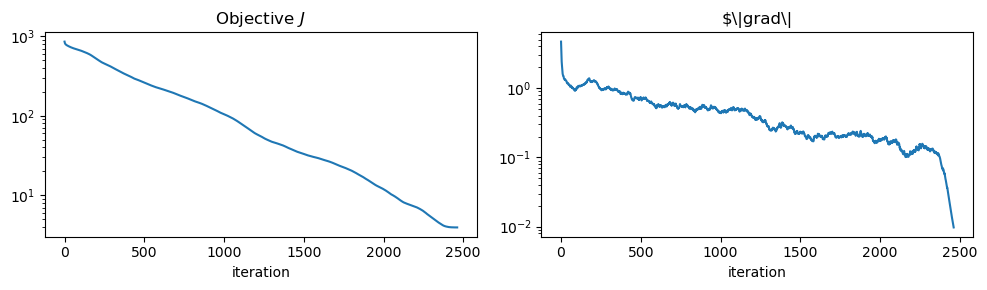

In [7]:
displacement, history = dic.run_dic(
    im_ref,
    im_def,
    disp_guess=disp_guess,
    max_iter=5000,
    tol=1e-2,
    reg_type="spring",
    alpha_reg=0.05,
)

hist = np.asarray(history)
print("Last solver state:", hist[-1])

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].semilogy(hist[:, 0])
ax[0].set_title("Objective $J$")
ax[0].set_xlabel("iteration")
ax[1].semilogy(hist[:, 1])
ax[1].set_title(r"$\|grad\|")
ax[1].set_xlabel("iteration")
plt.tight_layout()
plt.show()

[Nodal-spring_jacobi] sweep 1/10, J=3.7219e+00
[Nodal-spring_jacobi] sweep 2/10, J=4.7223e+00
[Nodal-spring_jacobi] sweep 3/10, J=4.9088e+00
[Nodal-spring_jacobi] sweep 4/10, J=4.9829e+00
[Nodal-spring_jacobi] sweep 5/10, J=5.0083e+00
[Nodal-spring_jacobi] sweep 6/10, J=5.0214e+00
[Nodal-spring_jacobi] sweep 7/10, J=5.0286e+00
[Nodal-spring_jacobi] sweep 8/10, J=5.0331e+00
[Nodal-spring_jacobi] sweep 9/10, J=5.0360e+00
[Nodal-spring_jacobi] sweep 10/10, J=5.0380e+00


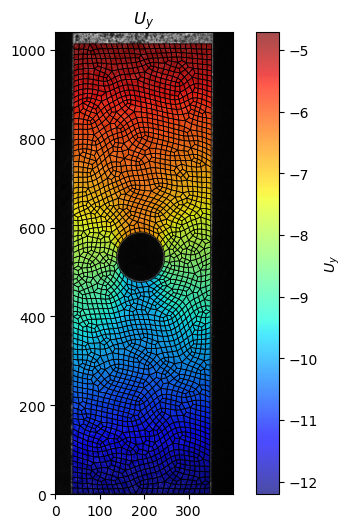

In [9]:
u_star = dic.run_dic_nodal(
    im_ref,
    im_def,
    disp_init=displacement,
    n_sweeps=10,
    lam=0.1,
    reg_type="spring_jacobi",
    alpha_reg=0.001,
    max_step=0.2,
    omega_local=0.5,
)

plotter_u = DICPlotter(
    background_image=im_def,
    displacement=np.asarray(u_star),
    dic_object=dic,
)
fig, _ = plotter_u.plot_displacement_component("Uy", image_alpha=0.7)
plt.show()

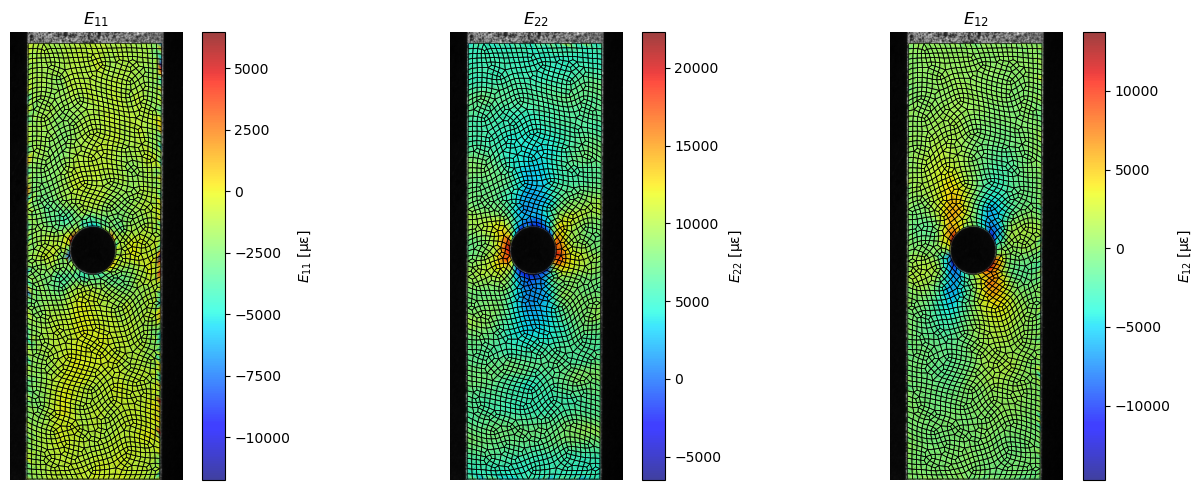

Stored linearization point: u_star shape (2651, 2)


In [10]:
F_star, E_star = dic.compute_green_lagrange_strain_nodes(
    u_star,
    k_ring=2,
    gauge_length=40.0,
)

plotter_ref = DICPlotter(
    background_image=im_def,
    displacement=np.asarray(u_star),
    strain_fields=(F_star, E_star),
    dic_object=dic,
)

component_names = ("Exx", "Eyy", "Exy")
strain_scale = 1e6
strain_unit_label = "µε"


def to_micro(values):
    'Convert strain values to micro-strain.'
    return strain_scale * values


def plot_scalar_field(ax, nodal_values, title, cmap="jet", alpha=0.75):
    ax.imshow(plotter_ref.background_image, cmap="gray", origin="lower", alpha=1.0)
    field_map = plotter_ref._interpolate_scalar_field(np.asarray(nodal_values))
    masked = np.ma.array(field_map, mask=~np.isfinite(field_map))
    mesh = ax.imshow(masked, cmap=cmap, origin="lower", alpha=alpha)
    quad_mesh = plotter_ref._quad_mesh_collection()
    if quad_mesh is not None:
        ax.add_collection(quad_mesh)
    ax.set_aspect("equal")
    ax.set_axis_off()
    ax.set_title(title)
    return mesh

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
for ax, name in zip(axes, component_names):
    values = to_micro(plotter_ref.strain_fields[name])
    title = plotter_ref._latex_label(name, "strain")
    mesh = plot_scalar_field(ax, values, title)
    fig.colorbar(mesh, ax=ax, fraction=0.046, pad=0.04, label=f"{title} [{strain_unit_label}]")
plt.tight_layout()
plt.show()

reference_strain_fields = {name: np.asarray(to_micro(plotter_ref.strain_fields[name])) for name in component_names}
node_coords = np.asarray(dic.node_coordinates_binned[:, :2])
print("Stored linearization point: u_star shape", np.asarray(u_star).shape)


## 3. Linearized Problem at Convergence
Let $r(u) = I_1 - I_2(u)$ gather the pixel residuals. Near the converged solution $u_\star$ we linearize
$$r(u_\star + \delta u) \approx r(u_\star) + J\, \delta u, \quad J = 



rac{\partial r}{\partial u}\Big|_{u_\star}.$$
The Gauss–Newton approximation of the Hessian is $H pprox J^	op J$, which is symmetric positive definite when the problem is well conditioned. We now focus on manipulating $J$ implicitly: accessing $Jv$ or $J^	op w$ is sufficient to apply $H$ to vectors and is much cheaper than forming $J$ explicitly (millions of entries for this ROI).

## 4. Implicit Gauss–Newton Operator
The residual evaluation already exists inside the D2IC solver; we wrap it into a pure JAX function of the nodal displacement so that `jax.jvp` provides $v \mapsto Jv$ and `jax.linear_transpose` provides $w \mapsto J^	op w$. Their composition implements $v \mapsto (J^	op J)v$ without ever assembling dense matrices. All quantities are expressed in binned pixel units so that the operator matches the solver's native scale.

In [11]:
binning = float(getattr(dic, "binning", 1.0))
u_star_binned = jnp.asarray(u_star) / binning
u_shape = u_star_binned.shape
n_dof = u_star_binned.size

im1_jax = jnp.asarray(im_ref, dtype=jnp.float32)
im2_jax = jnp.asarray(im_def, dtype=jnp.float32)
pixel_coords_ref = jnp.asarray(dic.pixel_coords_ref)
pixel_nodes = jnp.asarray(dic.pixel_nodes)
pixel_shapeN = jnp.asarray(dic.pixel_shapeN)

gradx2_np, grady2_np = compute_image_gradient(np.asarray(im_def))
gradx2 = jnp.asarray(gradx2_np)
grady2 = jnp.asarray(grady2_np)

@jax.jit
def residual_function(disp):
    r, _x_def, _gx_def, _gy_def = compute_pixel_state(
        disp,
        im1_jax,
        im2_jax,
        pixel_coords_ref,
        pixel_nodes,
        pixel_shapeN,
        gradx2,
        grady2,
    )
    return -(r)  # I1 - I2(u)

residual_at_solution = residual_function(u_star_binned)
print(f"Number of residuals: {residual_at_solution.size:,}")
print(f"DOFs (2 per node): {n_dof:,}")
print(f"RMS residual at u_star: {float(jnp.sqrt(jnp.mean(residual_at_solution**2))):.4f} gray levels")

flatten = lambda arr: jnp.reshape(arr, (-1,))
unflatten = lambda vec: jnp.reshape(vec, u_shape)
_, vjp_residual = jax.vjp(residual_function, u_star_binned)

@jax.jit
def apply_Jv(vec_flat):
    tangent = unflatten(vec_flat)
    return jax.jvp(residual_function, (u_star_binned,), (tangent,))[1]

@jax.jit
def apply_Jt(residual_vec):
    return flatten(vjp_residual(residual_vec)[0])

@jax.jit
def apply_JtJ(vec_flat):
    jv = apply_Jv(vec_flat)
    return apply_Jt(jv)

key_test = random.PRNGKey(0)
test_dir = random.normal(key_test, shape=(n_dof,))
matvec_test = apply_JtJ(test_dir)
print(f"Test matvec completed, output shape: {matvec_test.shape}")

Number of residuals: 300,757
DOFs (2 per node): 5,302
RMS residual at u_star: 3.1747 gray levels
Test matvec completed, output shape: (5302,)


## 5. Covariance Estimation of Displacement DOFs
Assuming a unit image noise scale $\sigma_I = 1.0$, the Laplace approximation gives
$$\operatorname{Cov}(u) \approx \sigma_I^2 (J^T J)^{-1}.$$
Directly inverting $J^	op J$ is impossible, but we can query selected entries of the inverse via CG solves. Hutchinson probing with Rademacher vectors $z$ provides an unbiased estimator of the diagonal: $\operatorname{diag}(A^{-1}) = \mathbb{E}[(A^{-1} z) \odot z]$ for $A = J^	op J$. Each probe entails one CG solve but keeps memory usage minimal. The resulting standard deviation maps describe how well each nodal DOF is observed by the image data, independently of any specific noise draw.

In [13]:
sigma_I = 1.0  # unit noise scale emphasises conditioning rather than absolute noise
cg_tol = 1e-6
cg_maxiter = 400

matvec = apply_JtJ  # alias for readability


def solve_normal_equations(rhs, tol=cg_tol, maxiter=cg_maxiter):
    sol, info = cg(matvec, rhs, tol=tol, maxiter=maxiter)
    info_val = 0 if info is None else int(info)
    if info_val != 0:
        print(f"Warning: CG reported info={info_val}")
    return sol

n_probes_cov = 12
key = random.PRNGKey(1)
cov_diag_accum = jnp.zeros(n_dof, dtype=u_star_binned.dtype)

for probe_id in range(n_probes_cov):
    key, subkey = random.split(key)
    bern = random.bernoulli(subkey, p=0.5, shape=(n_dof,))
    probe = (2.0 * bern.astype(u_star_binned.dtype)) - 1.0  # Rademacher vector
    sol = solve_normal_equations(probe)
    cov_diag_accum = cov_diag_accum + sol * probe
    if (probe_id + 1) % 4 == 0:
        print(f"Probe {probe_id + 1}/{n_probes_cov} completed")

cov_diag_flat = (sigma_I ** 2) * cov_diag_accum / float(n_probes_cov)
std_u_flat = jnp.sqrt(jnp.clip(cov_diag_flat, a_min=0.0))
std_u = jnp.reshape(std_u_flat, u_shape)
std_disp_fields = {"Ux": np.asarray(std_u[:, 0]), "Uy": np.asarray(std_u[:, 1])}
print(
    "Mean std(Ux) = {:.4e} px, mean std(Uy) = {:.4e} px".format(
        float(np.mean(std_disp_fields["Ux"])),
        float(np.mean(std_disp_fields["Uy"]))
    )
)

Probe 4/12 completed
Probe 8/12 completed
Probe 12/12 completed
Mean std(Ux) = 8.3873e-03 px, mean std(Uy) = 9.1083e-03 px


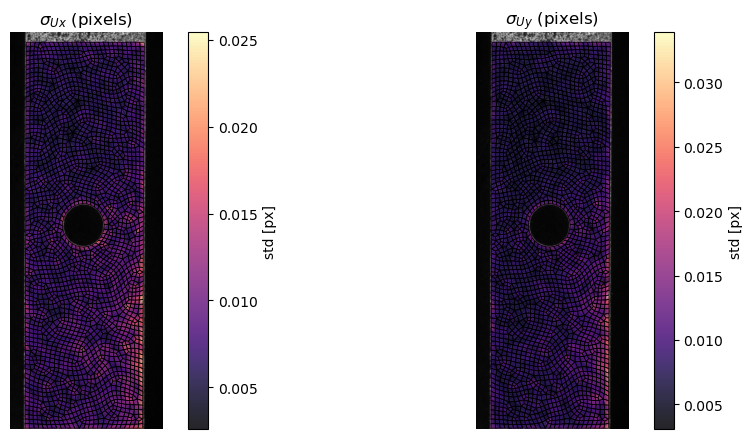

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharex=True, sharey=True)
for ax, name in zip(axes, ("Ux", "Uy")):
    values = std_disp_fields[name]
    title = rf"$\sigma_{{{name}}}$ (pixels)"
    mesh = plot_scalar_field(ax, values, title, cmap="magma", alpha=0.85)
    fig.colorbar(mesh, ax=ax, fraction=0.046, pad=0.04, label="std [px]")
plt.tight_layout()
plt.show()

## 6. Push-Forward to Strain Covariance
The nodal strain operator $E(u)$ is differentiable, so we form its Jacobian $G = \partial E/\partial u$ with respect to the two displacement components per node. The propagated variance follows
$$\operatorname{Var}(E) \approx \operatorname{diag}(G\, \operatorname{Cov}(u)\, G^T).$$
We again avoid explicit Jacobians by chaining JVPs/VJPs: $Gv$ is computed via `jax.jvp`, $G^	op w$ via `jax.linear_transpose`, and the covariance action $G (J^	op J)^{-1} G^	op$ is evaluated with CG solves. Hutchinson probing returns spatially varying standard deviations for $E_{xx}$, $E_{yy}$, and $E_{xy}$, all converted to $\mu \varepsilon$.

In [16]:
nodes_coord_binned = jnp.asarray(dic.node_coordinates_binned[:, :2])
node_neighbor_index = jnp.asarray(dic.node_neighbor_index)
node_neighbor_degree = jnp.asarray(dic.node_neighbor_degree)
node_neighbor_weight = jnp.asarray(dic.node_neighbor_weight)
gauge_length = 40.0

@jax.jit
def strain_function(disp):
    _F_all, E_all = compute_green_lagrange_strain_nodes_lsq(
        disp,
        nodes_coord_binned,
        node_neighbor_index,
        node_neighbor_degree,
        gauge_length=jnp.asarray(gauge_length),
    )
    return jnp.stack((E_all[:, 0, 0], E_all[:, 1, 1], E_all[:, 0, 1]), axis=0)

reference_strain_stack = strain_function(u_star_binned)
strain_shape = reference_strain_stack.shape
strain_size = reference_strain_stack.size
flatten_strain = lambda arr: jnp.reshape(arr, (-1,))
unflatten_strain = lambda vec: jnp.reshape(vec, strain_shape)
_, vjp_strain = jax.vjp(strain_function, u_star_binned)

@jax.jit
def apply_G(vec_flat):
    tangent = unflatten(vec_flat)
    jv = jax.jvp(strain_function, (u_star_binned,), (tangent,))[1]
    return flatten_strain(jv)

def apply_Gt(strain_vec_flat):
    strain_like = unflatten_strain(strain_vec_flat)
    return flatten(vjp_strain(strain_like)[0])

n_probes_strain = 12
key = random.PRNGKey(7)
strain_diag_accum = jnp.zeros(strain_size, dtype=u_star_binned.dtype)

for probe_id in range(n_probes_strain):
    key, subkey = random.split(key)
    bern = random.bernoulli(subkey, p=0.5, shape=(strain_size,))
    probe = (2.0 * bern.astype(u_star_binned.dtype)) - 1.0
    rhs = apply_Gt(probe)
    sol = solve_normal_equations(rhs)
    action = apply_G(sol)
    strain_diag_accum = strain_diag_accum + action * probe
    if (probe_id + 1) % 4 == 0:
        print(f"Probe {probe_id + 1}/{n_probes_strain} completed")

strain_var_flat = (sigma_I ** 2) * strain_diag_accum / float(n_probes_strain)
strain_std_flat = jnp.sqrt(jnp.clip(strain_var_flat, a_min=0.0))
strain_std_stack = jnp.reshape(strain_std_flat, strain_shape)
std_strain_fields = {name: strain_scale * np.asarray(strain_std_stack[i]) for i, name in enumerate(component_names)}
for name in component_names:
    print(
        f"mean σ_{name} = {np.mean(std_strain_fields[name]):.3f} {strain_unit_label}, "
        f"max σ_{name} = {np.max(std_strain_fields[name]):.3f} {strain_unit_label}"
    )

Probe 4/12 completed
Probe 8/12 completed
Probe 12/12 completed
mean σ_Exx = 325.901 µε, max σ_Exx = 2842.308 µε
mean σ_Eyy = 299.604 µε, max σ_Eyy = 2448.855 µε
mean σ_Exy = 230.886 µε, max σ_Exy = 1946.633 µε


## 7. Visualization and Interpretation
We now juxtapose the reference strain maps (already in $\mu



arepsilon$) with their Gauss–Newton standard deviation counterparts. Regions with poor texture, limited illumination, or boundary constraints exhibit inflated uncertainty, whereas strongly textured areas near the specimen middle remain well observed. Because the covariance stems from $(J^	op J)^{-1}$, it reflects the intrinsic observability of each strain component rather than the effect of a particular noise realization.

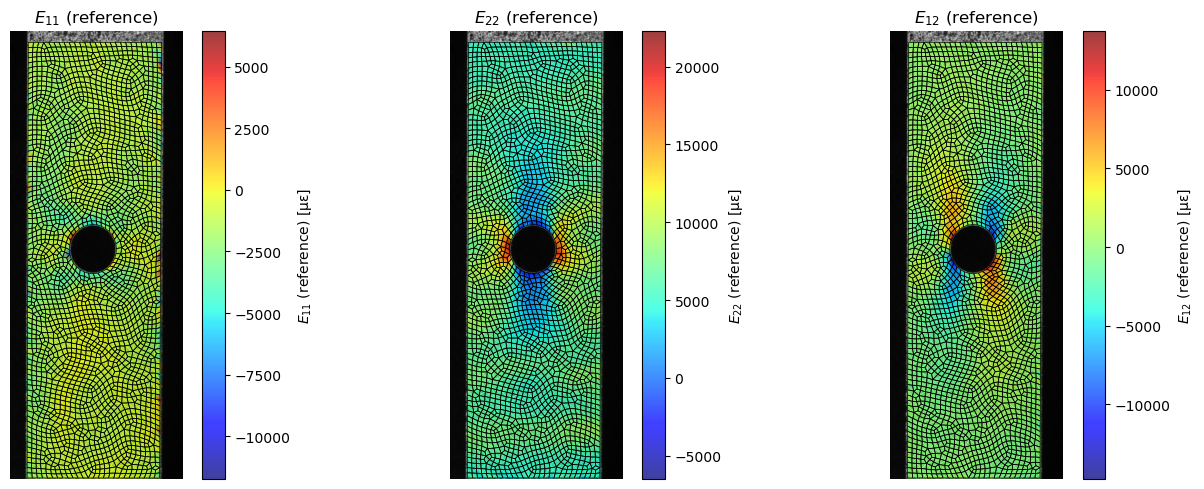

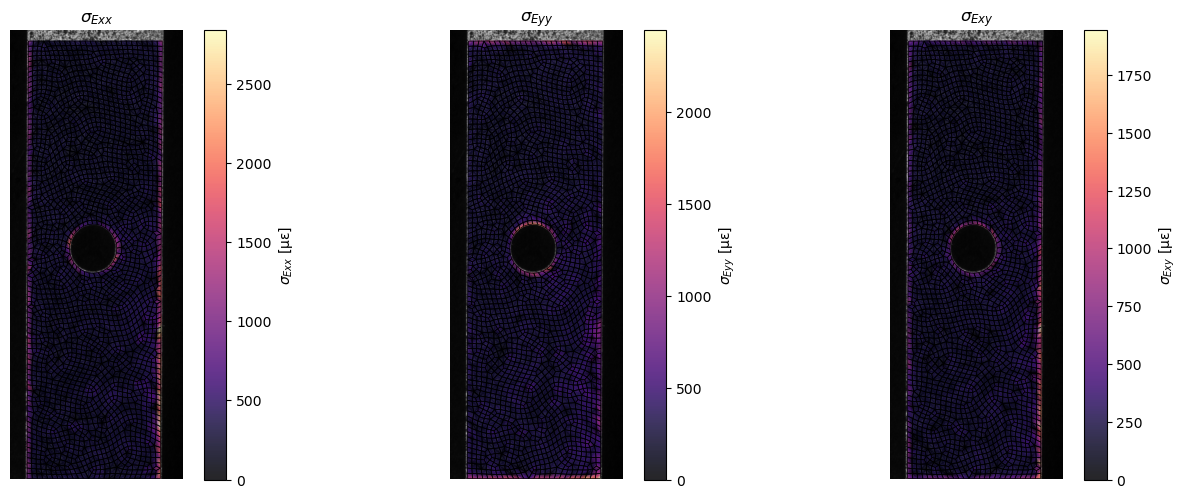

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
for ax, name in zip(axes, component_names):
    values = reference_strain_fields[name]
    title = plotter_ref._latex_label(name, "strain") + " (reference)"
    mesh = plot_scalar_field(ax, values, title)
    fig.colorbar(mesh, ax=ax, fraction=0.046, pad=0.04, label=f"{title} [{strain_unit_label}]")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
for ax, name in zip(axes, component_names):
    values = std_strain_fields[name]
    title = rf"$\sigma_{{{name}}}$"
    mesh = plot_scalar_field(ax, values, title, cmap="magma", alpha=0.85)
    fig.colorbar(mesh, ax=ax, fraction=0.046, pad=0.04, label=f"{title} [{strain_unit_label}]")
plt.tight_layout()
plt.show()

## 8. Discussion
- The Gauss–Newton covariance quantifies observability: low variances align with textured regions where pixel residuals tightly constrain nodal DOFs, while large variances concentrate near the hole boundary, along shadowed edges, and in mesh patches with scarce gray-level contrast.
- Unlike Monte Carlo noise injection, the present analysis depends only on $(J^	op J)^{-1}$ (problem conditioning) and the linearized strain operator. Consequently, the uncertainty maps describe how the solver amplifies or dampens infinitesimal perturbations regardless of which noise sample might be applied.
- Practical benefits include mesh design (refine or coarsen where the covariance indicates weak constraints), regularization tuning (increasing smoothing where observability is low), and confidence assessment when reporting strain extrema in experiments or SoftwareX reproducibility packages.
- Because everything relies on implicit JVP/VJP operations, extending the analysis to other objective terms (e.g., augmented regularizers or multi-physics couplings) only requires redefining the residual function; no dense Jacobian assembly is ever needed.